In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
from scipy import stats
from cooltools.lib import numutils

from akita_utils.format_io import h5_to_df
from akita_utils.tsv_utils import filter_dataframe_by_column
from akita_utils.analysis_utils import split_by_percentile_groups

import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import read_multi_model_single_flanks_data

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_flanks/single_insertion_flanks"

In [3]:
df = read_multi_model_single_flanks_data(data_dir)

In [19]:
# df

In [ ]:
# df_split_SCDins = split_by_percentile_groups(df, column_to_split="insertion_SCD", num_classes=5, 
#                                upper_percentile=100, lower_percentile=0, 
#                                category_colname="insSCD_group")

In [5]:
df_split_SCDins = df.sort_values(by='insertion_SCD').reset_index(drop=True)
df_split_SCDins.loc[:249, 'insSCD_group'] = 'Group_0'

total_rows = len(df_split_SCDins) - 250
rows_per_group = total_rows // 4

for i, group in enumerate(['Group_1', 'Group_2', 'Group_3', 'Group_4'], start=1):
    start_idx = 250 + (i - 1) * rows_per_group
    end_idx = start_idx + rows_per_group
    df_split_SCDins.loc[start_idx:end_idx, 'insSCD_group'] = group

df_split_SCDins.loc[250 + 3 * rows_per_group:, 'insSCD_group'] = 'Group_4'

In [ ]:
# group 4 is the stronges, group 0 the weakest

In [6]:
flank_df = df_split_SCDins.groupby(["insSCD_group", "flank_bp"]).agg({"SCD": "mean"}).reset_index()

In [7]:
color_dict = {"Group_0": "#9fc2e0",
              "Group_1": "#6da3d0",
              "Group_2":"#3b7fb9", 
              "Group_3":"#2d618e", 
              "Group_4":"#1d3f5c"}

## Plot with sites splited into 5 groups by percentiles

Text(0, 0.5, 'Insertion Score')

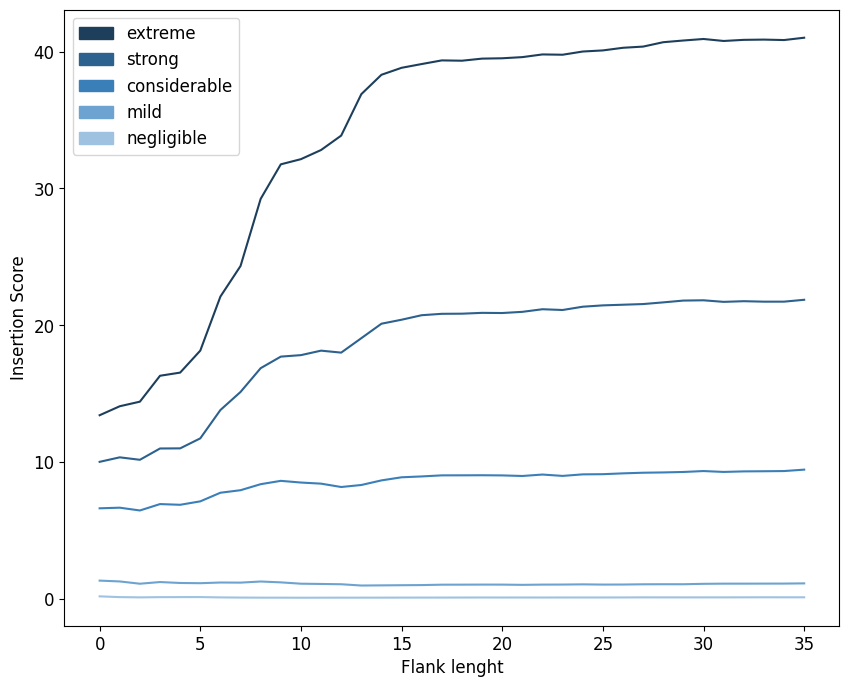

In [8]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, flank_df[(flank_df["insSCD_group"] == group)]["SCD"], 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="extreme")
gr3_patch = mpatches.Patch(color="#2d618e", label="strong")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="considerable")
gr1_patch = mpatches.Patch(color="#6da3d0", label="mild")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="negligible")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

## Plot with smoothed lines

In [9]:
bin_size = 11

Text(0, 0.5, 'Insertion Score')

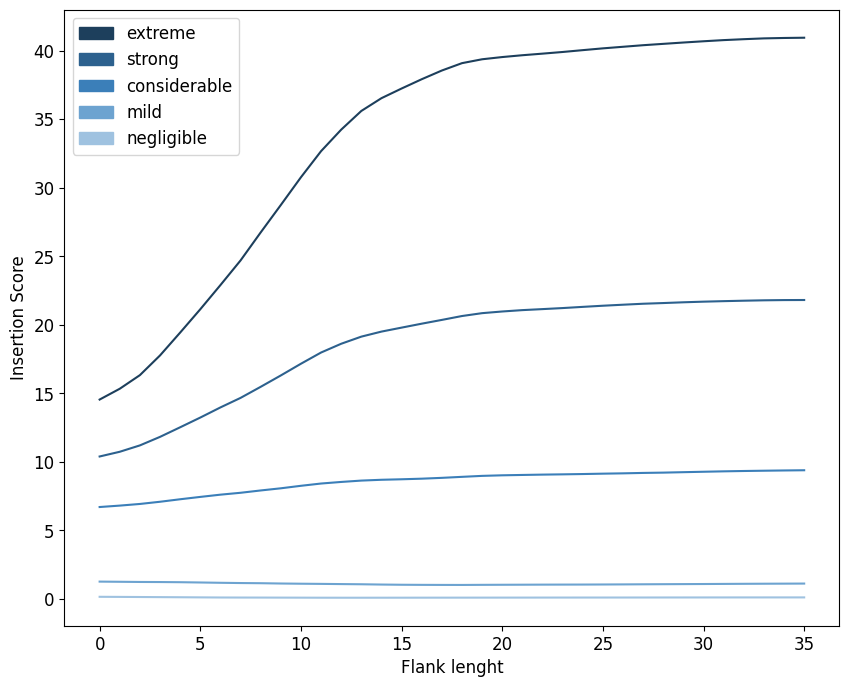

In [10]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD"], bin_size), 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="extreme")
gr3_patch = mpatches.Patch(color="#2d618e", label="strong")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="considerable")
gr1_patch = mpatches.Patch(color="#6da3d0", label="mild")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="negligible")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

## Plot with smoothed lines and 25-75 percentile bands

In [11]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [12]:
insSCDpercentiles_df = df_split_SCDins.groupby(["insSCD_group", "flank_bp"])["SCD"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

Text(0, 0.5, 'Insertion Score')

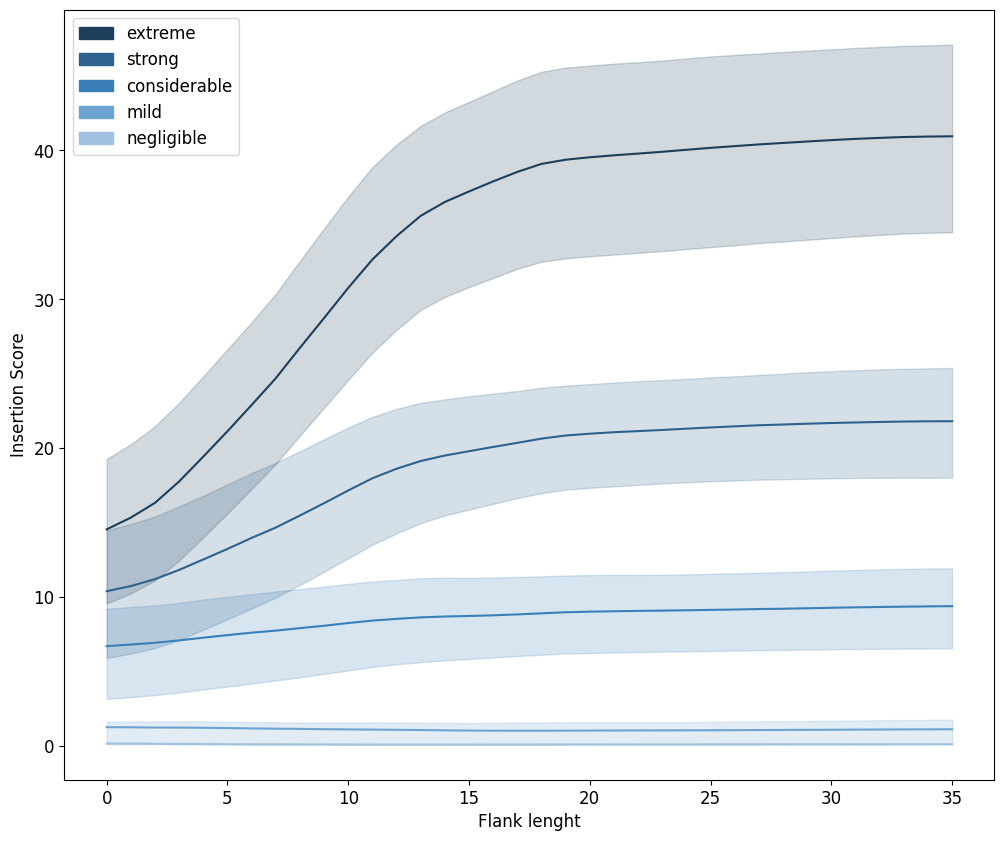

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="extreme")
gr3_patch = mpatches.Patch(color="#2d618e", label="strong")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="considerable")
gr1_patch = mpatches.Patch(color="#6da3d0", label="mild")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="negligible")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

## Plotting 10 random sites from high, medium, low insertion_SCD group

In [14]:
num_sites = 10
ten_high = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_4"].start.unique(), size=num_sites)
ten_medium = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_2"].start.unique(), size=num_sites)
ten_low = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_0"].start.unique(), size=num_sites)

In [15]:
to_plot = df_split_SCDins[df_split_SCDins["start"].isin(ten_high)][["chrom", "end", "start", "strand"]].drop_duplicates().reset_index(drop=True)

In [16]:
# to_plot.to_csv("random_10sites_top_class.tsv", sep="\t", index=False, header=True)

Text(0, 0.5, 'Insertion Score')

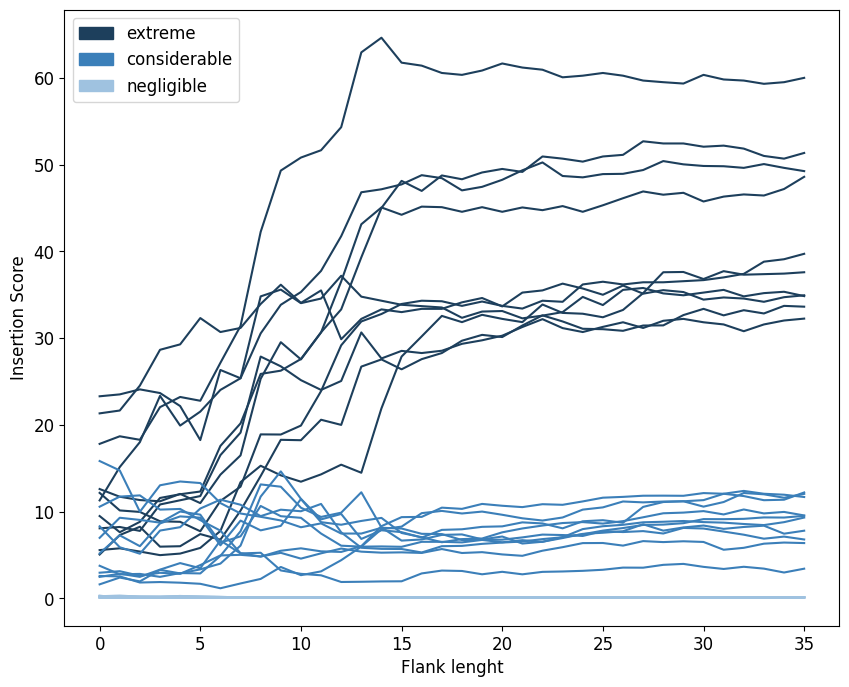

In [17]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#1d3f5c")

for start_pos in ten_medium:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#3b7fb9")

for start_pos in ten_low:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#9fc2e0")

gr4_patch = mpatches.Patch(color="#1d3f5c", label="extreme")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="considerable")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="negligible")
plt.legend(handles=[gr4_patch, gr2_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

## Plot with smoothed trends of 5 classes overlayed with 10 lines randomly chosen from the 'High'

Text(0, 0.5, 'Insertion Score')

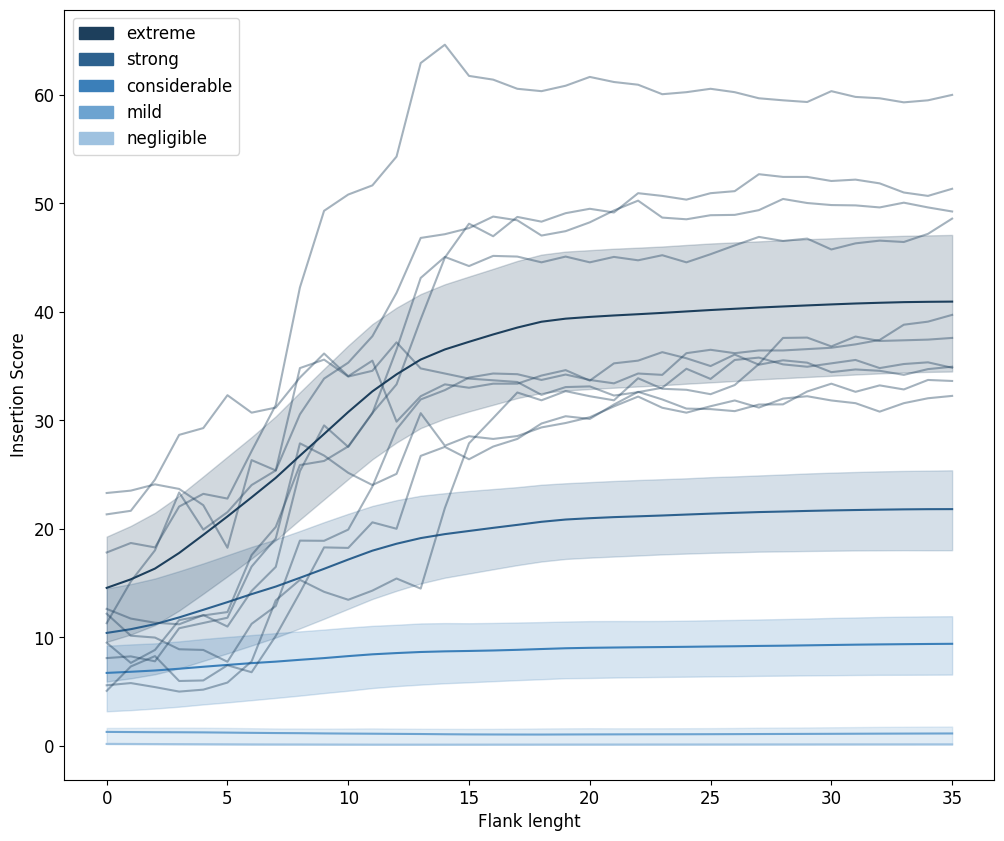

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="extreme")
gr3_patch = mpatches.Patch(color="#2d618e", label="strong")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="considerable")
gr1_patch = mpatches.Patch(color="#6da3d0", label="mild")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="negligible")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")
# plt.savefig("./plots/single_insertion_flank_length_vs_indertion_score_2.pdf", format="pdf", bbox_inches="tight")